# Introduction to weighting scores

A common task or goal in verification is to understand how the accuracy of a model varies, or account for it.

One of the most common factors to take into account is that most geospatial data arrays don't represent equal amounts of physical area at each coordinate, particularly for one of the most common representations, the "LLXY" representation whereby each part of the array represents some even subdivision of latitude and longitude. Without going into the details on why this happens, what's important to know is that those apparently equal subdivisions of latitude do not represent an equal area. Lines of longitude are physically closer together nearer the poles, and are further apart where latitude equals zero. This is taken into account by reducing the values towards the poles by 'weighting' the results. In this case, all the weights are less than or equal to 1.

Another common weighting is to account for the effect of accuracy on people, and so the results may be weighted by population density. In this case, the weightings could be greater than one, and increase the values in some places, depending on the expression of density. Any normalisation is the responsibility of the user when creating the weightings array. One approach could be to divide the weightings array by its maximum weight.

Weighting in this context means multiplying. Internally to the scores package, the process is as follows:

1. Calculate the underlying error metric for the score (e.g. absolute error)
2. Multiply those errors by a factor supplied to the algorithm (for example, latitude weighting or population density)
3. Perform dimensionality reduction (e.g. calculate the mean) of the weighted value

It is important to realise that this factor can greatly distort the intuitive meaning of the scores. Latitude weighting apply a maximum weighting of 1 at the equator (so no change), and reduce the errors significantly towards the poles, as the area represented by each region also reduces significatly (going to zero in the extreme). Latitude weighting by cosine (the method implemented in this package) is inherently normalised between zero and one.

Population density, by contrast, may not be normalised naturally. It could be expressed as a number of people per kilometer. In this case, perhaps it's appropriate to weight by both population density AND latitude/area. Perhaps it would also be useful to mask out oceans and lakes, since those areas don't impact the population in the same way.

Sometimes, it's useful to calculate a few different perspectives at once. A more complex example might be to compare the latitude-weighted score to a population-weighted one, meaning both things need to be collected.

This notebook will go through some examples from the simple to the complex, showing both the importance and significance of considering weighting when calculating verification scores.

**Note:** In this tutorial we use the forecast and analysis grids that are downloaded or derived in `First_Data_Fetching.ipynb`. Please run through this tutorial first to fetch data.

In [1]:
import io
import pandas
import scores
import xarray
import zipfile

# Note - while not imported, xarray depends on rasterio and rioxarray being installed to load the geotiffs
# for exploring population density in the latter part of the notebook

In [2]:
# Here we consider the errors at 4 days lead time into the prediction, at a specific hour, compared to the analysis for that time step.
forecast = xarray.open_dataset('forecast_grid.nc', decode_timedelta=True)
analysis = xarray.open_dataset('analysis_grid.nc', decode_timedelta=True)
time_step_of_interest = forecast.temp_scrn[24*4-1]

In [3]:
# The standard latitude weight array has a magnitude of around 1 at the equator, and reduce to zero approaching the poles
weights = scores.functions.create_latitude_weights(analysis.lat)
print(f"The maximum weighting in the array is {weights.max().values}. This has an insignificant floating point rounding error.")

The maximum weighting in the array is 0.9999994770895914. This has an insignificant floating point rounding error.


In [4]:
weights

<xarray.DataArray 'lat' (lat: 1536)> Size: 12kB
array([0.00102266, 0.00306796, 0.00511325, ..., 0.00511325, 0.00306796,
       0.00102266], shape=(1536,))
Coordinates:
  * lat      (lat) float64 12kB 89.94 89.82 89.71 89.59 ... -89.71 -89.82 -89.94
Attributes:
    long_name:  latitudes
    type:       uniform
    units:      degrees_north
    valid_min:  -90.0
    valid_max:  90.0
    axis:       Y

In [5]:
# We will use a neutral weighting to confirm that nothing strange is happening. You could experiment with
# creating a population density weights array to contrast different weighting strategies
ones = weights.where(weights == 1, other=1)  

In [6]:
unweighted_mae = scores.continuous.mae(time_step_of_interest, analysis.temp_scrn, reduce_dims='lon')
neutral_mae = scores.continuous.mae(time_step_of_interest, analysis.temp_scrn, weights=ones, reduce_dims='lon')
weighted_mae = scores.continuous.mae(time_step_of_interest, analysis.temp_scrn, weights=weights, reduce_dims='lon')

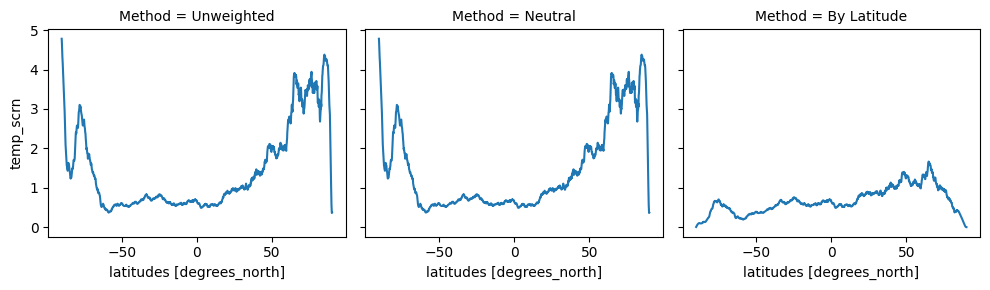

In [7]:
# Figure One - Side by Side Comparison of alternative weighting strategies
names = pandas.Index(['Unweighted', 'Neutral', 'By Latitude'], name="Method")
xarray.concat([unweighted_mae, neutral_mae, weighted_mae], dim=names).plot(col='Method')

The effect of weighting by area is quite dramatic. Let's download population density data and see the impact of that. Unfortunately, population density information is not quite so simple to work with as latitude weighting. There are a large number of different sources, in a variety of different structures, ranging from average density per country as a simple listing through to 1km global data. Many of these data sets have some level of restriction or signup required to access them. 

For the same of demonstration in a tutorial, we will be working Australian population density data, provided as a direct download by the Australian Bureau of Statistics (see https://www.abs.gov.au/statistics/people/population/regional-population/2021-22). We will then examine the impact of weightings considered over the Australian region.

In [8]:
# This is a basic file fetch only. Do not rely on it for untrusted data. A basic check has been included to make sure the
# downloaded file matches what was expected.

import hashlib
import os
import requests

def basic_fetch(url, filename, expected_hash):
    if os.path.exists(filename):
        print("File already exists, skipping download")
    else:
        response = requests.get(url, allow_redirects=True)
        if response.ok:
            outfile = open(filename, 'wb')  # This will write the file out to the current directory, typically where this notebook is being run
            outfile.write(response.content)        
            
    content = open(filename, 'rb').read()
    found_hash = hashlib.sha256(content).hexdigest()
    if found_hash != expected_hash:
        os.remove(filename)
        print("File has unexpected contents. The file has been removed - please download manually and check the data carefully")
        

In [9]:
# Fetch the data for the tutorial as a zip file

data_url = 'https://www.abs.gov.au/statistics/people/population/regional-population/2021-22/Australian_Population_Grid_2022_in_GEOTIFF_format.zip'
filename = 'auspopn.zip'
data_hash = 'a14172681cd343f69150de7f2939f1102aba1e7f6fe1aebde0e87c45069032a2' # Taken 23/8/23
basic_fetch(data_url, filename, data_hash)    

In [10]:
zf = zipfile.ZipFile('auspopn.zip', 'r')          # Open the zip file
popntiff = zf.read('apg22r_1_0_0.tif')            # Read the geotiff data file from the archive into memory
bytes = io.BytesIO(popntiff)                      # Create an in-memory file-like object from the data
auspop = xarray.open_dataset(bytes, engine='rasterio', band_as_variable=True)   # Open as an xarray, with hints for rasterio
auspop = auspop.rio.reproject("EPSG:4326")        # Move from x/y coords to lat/lon values
auspop = auspop.rename({'x': 'lon', 'y': 'lat'})  # Rename axes for consistency
auspop = auspop.band_1                            # Focus on the variable of interest
auspop_lr = auspop.coarsen({'lat': 4, 'lon': 4}, boundary='trim').mean()  # Reduce the resolution to closer to the data

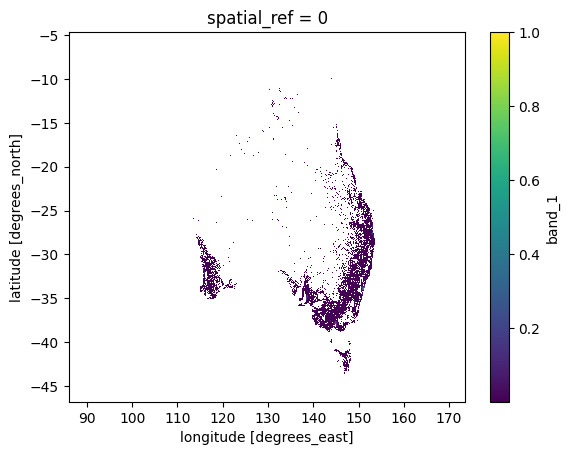

In [11]:
# The population density is -1 over the ocean and 0 for much of Australia
# It is best to mask to positive values and leave NaN elsewhere, but this could vary by situation
auspop_normalised = auspop_lr.where(auspop_lr > 0) / auspop_lr.max()  # Obtain the population density between 0 and 1
auspop_normalised.plot()

In [12]:
# Crop all data to the Australian Region

min_lon = 100 
max_lon = 160
min_lat = -5
max_lat = -45


fcst_aus = time_step_of_interest.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
anal_aus = analysis.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
lat_weight_aus = weights.sel(lat=slice(min_lat,max_lat))  # no lons included, uses broadcasting
popn_density_aus = auspop_normalised.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
popn_density_aus = popn_density_aus.interp_like(anal_aus)
aus_popn_neutrual = (popn_density_aus / popn_density_aus)

In [13]:
aus_unweighted_mae = scores.continuous.mae(fcst_aus, anal_aus.temp_scrn, reduce_dims='lon')
aus_lat_weighted_mae = scores.continuous.mae(fcst_aus, anal_aus.temp_scrn, weights=lat_weight_aus, reduce_dims='lon')
aus_popn_weighted_mae = scores.continuous.mae(fcst_aus, anal_aus.temp_scrn, weights=popn_density_aus, reduce_dims='lon')
aus_popn_neutral_mae = scores.continuous.mae(fcst_aus, anal_aus.temp_scrn, weights=aus_popn_neutrual, reduce_dims='lon')

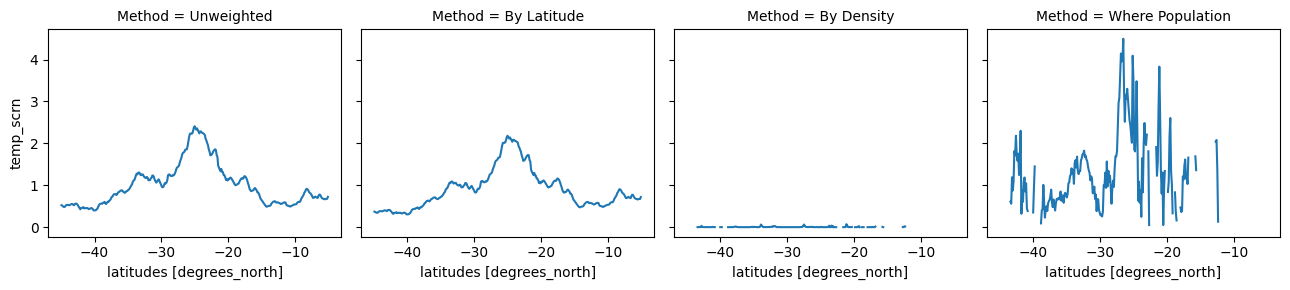

In [14]:
# Figure One - Side by Side Comparison of alternative weighting strategies
names = pandas.Index(['Unweighted', 'By Latitude', 'By Density', 'Where Population'], name="Method")
xarray.concat([aus_unweighted_mae, aus_lat_weighted_mae, aus_popn_weighted_mae, aus_popn_neutral_mae], dim=names).plot(col='Method')

A few interesting things can be seen here.

1. Weighting by latitude has relatively low impact over just Australia, despite its large land mass
2. Weighting by population density greatly reduces the scores in most of Australia, due to the huge peaks in cities
3. Effectively masking to populated areas increases the score, showing the forecast accuracy is worse than the aggregate indicator would suggest - for almost everyone

A more sophisticated normalisation strategy for calculating the population density error weightings, which also weights by latitude would probably give a more realistic picture of the impact of forecast error on the world population than any of the approximations listed here.